In [1]:
from finn.util.basic import make_build_dir
from finn.util.visualization import showSrc, showInNetron

In [2]:
import onnx

In [65]:
from torch.nn import Module
import torch.nn.functional as F
from brevitas.nn import QuantIdentity, QuantConv2d, QuantReLU, QuantLinear
from brevitas.core.quant import QuantType

class QuantLeNet(Module):
    def __init__(self, input_width, weight_width, act_width):
        
        super(QuantLeNet, self).__init__()
        self.quant_inp = QuantIdentity(bit_width=input_width, min_val=-1.0, max_val=1.0)
        
        self.conv1 = QuantConv2d(1, 6, 5, weight_bit_width=weight_width)
        self.conv2 = QuantConv2d(6, 16, 5, weight_bit_width=weight_width)
        self.fc1   = QuantLinear(16*4*4, 120, bias=True, weight_bit_width=weight_width)
        self.fc2   = QuantLinear(120, 84, bias=True, weight_bit_width=weight_width)
        self.fc3   = QuantLinear(84, 10, bias=False, weight_bit_width=weight_width)
        
        self.relu1 = QuantReLU(bit_width=act_width, max_val=6)
        self.relu2 = QuantReLU(bit_width=act_width, max_val=6)
        self.relu3 = QuantReLU(bit_width=act_width, max_val=6)
        self.relu4 = QuantReLU(bit_width=act_width, max_val=6)

    def forward(self, x):
        out = self.quant_inp(x)
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.relu3(self.fc1(out))
        out = self.relu4(self.fc2(out))
        out = self.fc3(out)
        return out

In [66]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [31]:
%%bash
pwd

/workspace/finn/notebooks/LeNet


In [121]:
DATASET_ROOT = "/workspace/finn/src/data/fashion"
BATCH_SIZE = 50

# percentage of training data
VAL_RATIO = 0.1

In [122]:
train_data = torchvision.datasets.FashionMNIST(DATASET_ROOT, train=True, transform=transform)

val_data, train_data = torch.utils.data.random_split(train_data, [len()])

test_data = torchvision.datasets.FashionMNIST(DATASET_ROOT, train=False, transform=transform)

In [123]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

classes = ('t-shirt/top', 'trouser', 'pullover', 'dress', \
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

In [124]:
%matplotlib inline

In [125]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

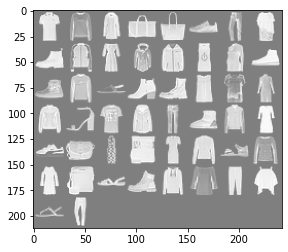

t-shirt/top pullover  coat   bag   bag sneaker trouser dress ankle boot  coat dress  coat  coat t-shirt/top pullover ankle boot ankle boot pullover sandal ankle boot ankle boot shirt shirt dress  coat sandal t-shirt/top  coat trouser ankle boot  coat dress sneaker   bag dress   bag dress  coat sandal pullover dress   bag sandal ankle boot pullover shirt trouser pullover sandal trouser


In [126]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))


In [140]:
import torch.optim as optim

def trainModel(net, max_epochs, val_dl, train_dl,path):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    
    best_state_dict = net.state_dict()
    best_val_loss = 10000000
    
    times_validation_increases = 0
    
    running_loss = 0.0
    for epoch in range(max_epochs):
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            if i % 50 == 49:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.8f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
        
        # find our best model
        val_loss = 0
        for i, data in enumerate(val_dl):
            inputs, labels = data

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            val_loss += loss.item()

        if val_loss < best_val_loss:
            best_state_dict = net.state_dict()
            best_val_loss = val_loss

            times_validation_increases = 0
            print ('New Best Validation:[epoch #%d] loss: %.8f' % (epoch+1, val_loss/(i+1)))
        else:
            times_validation_increases += 1
            
        
        if times_validation_increases == 3:
            print ("We are overfitting to the training set")
            break

        
    torch.save(best_state_dict, path)
    return best_state_dict

In [128]:
qnet = QuantLeNet(8,4,8)

In [129]:
best_model_weights = trainModel(qnet, 1000, valloader, valloader, "./good_model.pth")

[1,    50] loss: 2.29821852
[1,   100] loss: 2.26633920
[1,   150] loss: 2.12016974
[1,   200] loss: 1.75329589
New Best Validation:[epoch #1] loss: 1.53974523
[2,    50] loss: 1.36507528
[2,   100] loss: 1.20064806
[2,   150] loss: 1.08008540
[2,   200] loss: 1.00828106
New Best Validation:[epoch #2] loss: 1.00266686
[3,    50] loss: 0.94740596
[3,   100] loss: 0.94196441
[3,   150] loss: 0.89403955
[3,   200] loss: 0.88771291
New Best Validation:[epoch #3] loss: 0.90077730
[4,    50] loss: 0.85390922
[4,   100] loss: 0.85605591
[4,   150] loss: 0.80432535
[4,   200] loss: 0.82348661
New Best Validation:[epoch #4] loss: 0.83596080
[5,    50] loss: 0.82130674
[5,   100] loss: 0.78336476
[5,   150] loss: 0.81196600
[5,   200] loss: 0.75145707
New Best Validation:[epoch #5] loss: 0.79777105
[6,    50] loss: 0.77276821
[6,   100] loss: 0.77983897
[6,   150] loss: 0.74840191
[6,   200] loss: 0.75697067
New Best Validation:[epoch #6] loss: 0.77634252
[7,    50] loss: 0.73253657
[7,   100] l

In [71]:
best_model_weights

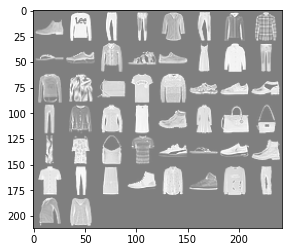

GroundTruth:  ankle boot pullover trouser trouser shirt trouser  coat shirt sandal sneaker  coat sandal sneaker dress  coat trouser pullover  coat   bag t-shirt/top pullover sandal sneaker ankle boot trouser  coat shirt t-shirt/top ankle boot dress   bag   bag dress dress   bag t-shirt/top sneaker sandal sneaker ankle boot shirt trouser dress sneaker shirt sneaker pullover trouser pullover pullover


In [131]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [132]:
bestNet = QuantLeNet(8,4,8)
bestNet.load_state_dict(torch.load("./good_model.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [134]:
outputs = bestNet(images)

In [135]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(BATCH_SIZE)))


Predicted:  ankle boot pullover trouser trouser shirt trouser shirt shirt sandal sneaker  coat sandal   bag dress  coat trouser shirt pullover   bag t-shirt/top pullover sneaker sneaker sandal trouser shirt  coat dress ankle boot dress   bag   bag dress t-shirt/top   bag t-shirt/top sneaker sandal sneaker ankle boot t-shirt/top trouser  coat ankle boot pullover sandal pullover trouser pullover pullover


In [137]:
def test(path, bestNet, test_dl):
    bestNet.load_state_dict(torch.load(path))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = bestNet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(BATCH_SIZE):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    print ('-'*80)

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    

Accuracy of the network on the 10000 test images: 72 %


In [141]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = bestNet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of t-shirt/top : 74 %
Accuracy of trouser : 91 %
Accuracy of pullover : 51 %
Accuracy of dress : 71 %
Accuracy of  coat : 62 %
Accuracy of sandal : 85 %
Accuracy of shirt : 26 %
Accuracy of sneaker : 86 %
Accuracy of   bag : 87 %
Accuracy of ankle boot : 91 %
